## Vehicle Health Analytics

In [ ]:
%pip install dremio-simple-query
from dremio_simple_query.connect import get_token
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Get credentials from environment
DREMIO_USER = os.getenv("DREMIO_USER")
DREMIO_PASSWORD = os.getenv("DREMIO_PASSWORD")

# URL to Login Endpoint
login_endpoint = "http://localhost:9047/apiv2/login"

# Payload for Login
payload = {
    "userName": DREMIO_USER,
    "password": DREMIO_PASSWORD
}

# Get token from API
token = get_token(login_endpoint, payload)

In [5]:
from pyarrow import flight
import pandas as pd

# Connect to Dremio Flight Server
client = flight.connect("grpc+tcp://localhost:32010")

# Authenticate with the token
headers = [
    (b'authorization', f'Bearer {token}'.encode('utf-8')),
]

# Query to get all products reviews
sql = "SELECT * FROM catalog.silver.vehicle_health_logs"

# Create a get all product reviews
descriptor = flight.FlightDescriptor.for_command(sql)

# Perform the query using call_options to include headers
options = flight.FlightCallOptions(headers=headers)
flight_info = client.get_flight_info(descriptor, options)
reader = client.do_get(flight_info.endpoints[0].ticket, options)

# Convert to Pandas DataFrame
vehicle_health = reader.read_pandas()

# Display the first few rows of the DataFrame
vehicle_health.head()

,VehicleID,Model,ManufacturingYear,Alerts,MaintenanceHistory
0,VEH20442,AeroFlow,2021,"[{'AlertID': 'ALERT8942', 'Date': '2021-01-25'...","[{'Date': '2023-05-10', 'Details': {'BatteryHe..."
1,VEH23016,AeroFlow,2024,"[{'AlertID': 'ALERT7020', 'Date': '2020-05-08'...","[{'Date': '2022-12-05', 'Details': {'BatteryHe..."
2,VEH67132,AeroFlow,2023,"[{'AlertID': 'ALERT5049', 'Date': '2022-02-06'...","[{'Date': '2023-05-16', 'Details': {'BatteryHe..."
3,VEH31263,EcoSprint,2022,"[{'AlertID': 'ALERT9173', 'Date': '2021-08-25'...","[{'Date': '2024-06-18', 'Details': {'BatteryHe..."
4,VEH62953,UrbanGlide,2022,"[{'AlertID': 'ALERT8582', 'Date': '2020-02-18'...","[{'Date': '2022-11-21', 'Details': {'BatteryHe..."


## 1. Maintenance frequency analysis

In [7]:
import pandas as pd
from pandas import json_normalize

# Flatten MaintenanceHistory
maintenance_records = json_normalize(vehicle_health['MaintenanceHistory'].explode().dropna())

# Analysis: Maintenance Frequency
maintenance_frequency = maintenance_records['Type'].value_counts()

# Display the maintenance frequency
print("Maintenance Frequency:")
print(maintenance_frequency)

Maintenance Frequency:
Type
Tire Rotation        2429
Battery Check        2416
Brake Inspection     2392
Engine Diagnostic    2388
Name: count, dtype: int64


## 2. Outcome analysis

In [8]:
# Flatten Alerts
alerts_records = json_normalize(vehicle_health['Alerts'].explode().dropna())

# Analysis: Alerts Frequency
alerts_frequency = alerts_records['Type'].value_counts()
print("\nAlerts Frequency:")
print(alerts_frequency)


Alerts Frequency:
Type
Engine Warning              2129
High Battery Temperature    2119
Low Tire Pressure           2108
Name: count, dtype: int64


## 3. Alerts analysis

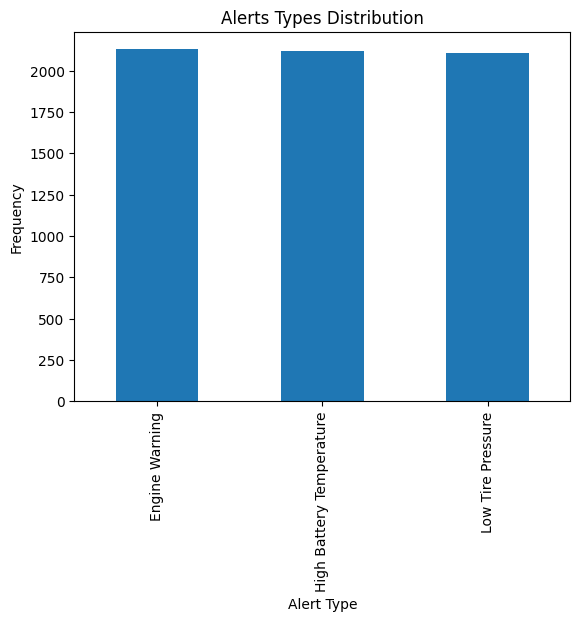

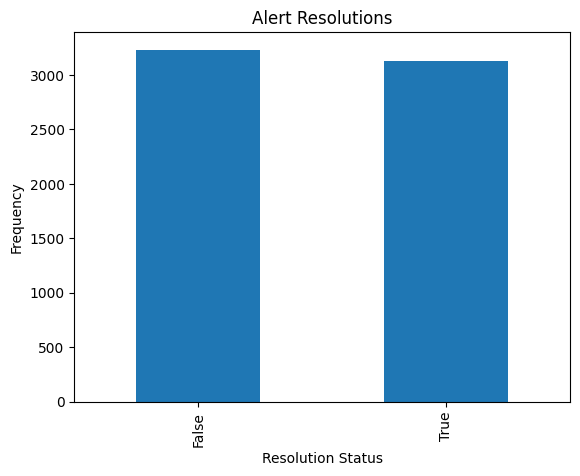

In [13]:
import matplotlib.pyplot as plt

# Plot Alerts Analysis
alerts_types = alerts_records['Type'].value_counts()
alerts_types.plot(kind='bar', title='Alerts Types Distribution')
plt.xlabel('Alert Type')
plt.ylabel('Frequency')
plt.show()


# Plot alter resolutions
alerts_resolutions = alerts_records['Resolved'].value_counts()
alerts_resolutions.plot(kind='bar', title='Alert Resolutions')
plt.xlabel('Resolution Status')
plt.ylabel('Frequency')
plt.show()